# Extracting parameters and plotting EMGs

In [1]:
import os
import numpy as np
import pandas as pd
import scipy.stats as spss
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
import arviz as az

plt.style.use("seaborn-ticks")

column_types={"time":"float16", #declaring types to go easy on RAM
              "EMG_L":"float16",
              "EMG_R":"float16",
              "participant":"category",
              "condition":"category"
        }


In [ ]:
epochPath = "../../data/EMG/Epochs_stim/"
list_dir = os.listdir(epochPath)
list_raw, list_parameters = [],[]
for f in list_dir:
    dropped = 0
    if 'partie 2' not in f.split('_')[0]:
        print(f.split('_')[0])
        raw_ = pd.read_table(epochPath+f, header=0, sep=',',skipinitialspace=True,
                     usecols=["epoch","time","condition","EMG_L","EMG_R"])
        raw_['rolling_L'] = np.nan
        raw_['rolling_R'] = np.nan
        meanL, meanR = [],[]
        raw_.EMG_L = np.abs(raw_.EMG_L)
        raw_.EMG_R = np.abs(raw_.EMG_R)
        for epoch, epoch_dat in raw_.groupby('epoch'):
            if epoch_dat.EMG_L.mean() < raw_.EMG_L.std()*3 and epoch_dat.EMG_R.mean() < raw_.EMG_R.std()*3:
                raw_.loc[raw_.epoch == epoch, "rolling_L"] = epoch_dat["EMG_L"].rolling(int(.05*2048)).mean()
                raw_.loc[raw_.epoch == epoch, "rolling_R"] = epoch_dat["EMG_R"].rolling(int(.05*2048)).mean()
                meanL.append(raw_.loc[(raw_.epoch == epoch) & (raw_.time >= -0.05)& (raw_.time <= 0), "rolling_L"].mean())
                meanR.append(raw_.loc[(raw_.epoch == epoch) & (raw_.time >= -0.05)& (raw_.time <= 0), "rolling_R"].mean())
            else : 
                dropped += 1
                raw_.loc[raw_.epoch == epoch, "rolling_L"] = np.nan
                raw_.loc[raw_.epoch == epoch, "rolling_R"] = np.nan
                meanL.append(np.nan)
                meanR.append(np.nan)
        del raw_['EMG_L']
        del raw_['EMG_R']
        raw_['SAT'], raw_['direction'], raw_['p_right'] = \
               zip(*raw_['condition'].map(lambda y: y.split('/')))
        del raw_['condition']
        #################### Extracting slope and baseline
        parameters = raw_.groupby(['epoch','SAT','p_right','direction'])['rolling_R','rolling_L'].mean().reset_index()
        parameters['meanL'] = meanL
        parameters['meanR'] = meanR
        parameters['participant'] = f.split('_')[0]
        list_parameters.append(parameters)
        #####################" Average time cours of participant"
        raw_ = raw_.groupby(['p_right','SAT','time','direction']).mean().reset_index()
        raw_['participant'] = f.split('_')[0]
        list_raw.append(raw_)
        print(dropped)

df_EMG_averages_tc = pd.concat(list_raw, ignore_index=True)
df_EMG_parameters = pd.concat(list_parameters, ignore_index=True)

df_EMG_parameters['SAT'] = df_EMG_parameters.SAT.replace(['Acc','Spd'], ['accuracy','speed'])
df_EMG_averages_tc['SAT'] = df_EMG_averages_tc.SAT.replace(['Acc','Spd'], ['accuracy','speed'])

df_EMG_averages_tc.to_csv("EMG_averages_tc_stimc_rolling.csv")
df_EMG_parameters.to_csv("EMG_baseline_rolling.csv")

In [2]:
df_EMG_averages_tc = pd.read_csv("EMG_averages_tc_stimc_rolling.csv")
df_EMG_parameters = pd.read_csv("EMG_baseline_rolling.csv")
df_Force_averages_tc = pd.read_csv("Force_averages_tc_stimc_rolling.csv")
df_Force_parameters = pd.read_csv("Force_baseline_rolling.csv")

In [3]:
Rrecoded_parameters = df_EMG_parameters.copy()
Rrecoded_parameters['channel'] = Rrecoded_parameters.meanR
Rrecoded_parameters['EMG'] = 'right'

Lrecoded_parameters = df_EMG_parameters.copy()
Lrecoded_parameters['channel'] = Lrecoded_parameters.meanL
Lrecoded_parameters['EMG'] = 'left'

recoded_parameters = Rrecoded_parameters.append(Lrecoded_parameters)
recoded_parameters.to_csv('EMG_baseline_recoded.csv')

In [4]:
recoded_parameters = pd.read_csv('EMG_baseline_recoded.csv')

In [5]:
Rrecoded_tc = df_EMG_averages_tc.copy()
Rrecoded_tc['channel'] = Rrecoded_tc.rolling_R
Rrecoded_tc['EMG'] = 'right'

Lrecoded_tc = df_EMG_averages_tc.copy()
Lrecoded_tc['channel'] = Lrecoded_tc.rolling_L
Lrecoded_tc['EMG'] = 'left'

recoded_tc = Rrecoded_tc.append(Lrecoded_tc)

## Plotting mean time course of EMG

In [7]:
Rmean_df = df_EMG_averages_tc[df_EMG_averages_tc.p_right == 70].copy()
Rmean_df['cued'] = 'Cued'
Rmean_df['rolling'] = Rmean_df.rolling_R
NRmean_df = df_EMG_parameters[df_EMG_parameters.p_right == 70].copy()
NRmean_df['cued'] = 'NonCued'
NRmean_df['rolling'] = Rmean_df.rolling_L
NRmean_df = df_EMG_parameters[df_EMG_parameters.p_right == 50].copy()
NRmean_df['cued'] = 'NonCued'
NRmean_df['rolling'] = Rmean_df.rolling_L

Lmean_df = df_EMG_parameters[df_EMG_parameters.p_right == 30].copy()
Lmean_df['cued'] = 'Cued'
Lmean_df['baseline'] = Lmean_df.meanL
NLmean_df = df_EMG_parameters[df_EMG_parameters.p_right == 30].copy()
NLmean_df['cued'] = 'NonCued'
NLmean_df['baseline'] = Lmean_df.meanR

mean_df = Rmean_df.append([Lmean_df,NLmean_df, NRmean_df])

In [ ]:
df_EMG_averages_tc["valid"] = df_EMG_averages_tc.apply(lambda row : "valid" if row['direction'] == "D" and row['p_right'] == 70 else 
                   ("valid" if row['direction'] == "G" and row['p_right'] == 30 else 
                   ("even" if row['p_right'] == 50 else "invalid" )), axis = 1)

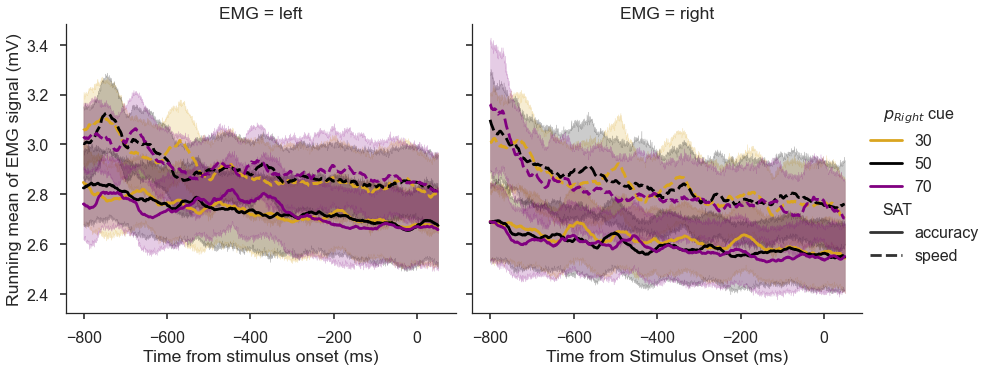

In [96]:
#fig, ax = plt.subplots(dpi=300, figsize=(5,2))
plt.style.use('seaborn-poster')

grp_avrg = recoded_tc.groupby(['participant','p_right','SAT','time','EMG']).mean().reset_index()
grp_avrg.time = grp_avrg.time*1000
grp_avrg[r'$p_{Right}$ cue'] = grp_avrg['p_right']
grp_avrg['Time from stimulus onset (ms)'] = grp_avrg['time']
grp_avrg['Running mean of EMG signal (mV)'] = grp_avrg.channel
sns.relplot(data=grp_avrg, x='Time from stimulus onset (ms)', y="Running mean of EMG signal (mV)", col="EMG", hue=r'$p_{Right}$ cue', ci=65, style="SAT", palette=['goldenrod','k','purple'],legend=True,kind="line",aspect=1.2)
#plt.xlim(-850, 50)
#plt.vlines(-750, 2.5,5,colors='k',ls=':')
#plt.vlines(0, 2.5,5,colors='k')
#plt.ylim(2.4,3.5)
plt.ylabel(r'Running mean of EMG (mV)')
plt.xlabel('Time from Stimulus Onset (ms)')
plt.savefig("../baselineEMG.png", dpi=600, bbox_inches='tight')

## Fitting LMM on baseline 

In [108]:
LMEdata = recoded_parameters[np.abs(recoded_parameters.channel) < recoded_parameters.channel.std()*3].copy()
print(LMEdata.head())
LMEdata['SAT'] = LMEdata.apply(lambda row: 0 if row['SAT'] == "speed" else 1, axis=1)
LMEdata['p_right'] = LMEdata.apply(lambda row: -0.5 if row['p_right'] == 30 else (
        0.5 if row['p_right'] == 70 else 0), axis=1)
LMEdata['EMG'] =  LMEdata.apply(lambda row: 0 if row['EMG'] == "left" else 1, axis=1)
print(LMEdata.participant.unique())
print(np.arange(len(LMEdata.participant.unique()))+1)
LMEdata['participant'] = LMEdata.participant.replace(LMEdata.participant.unique(), np.arange(len(LMEdata.participant.unique()))+1) 
LMEdata = LMEdata[["channel","participant",
                   "SAT","EMG","p_right"]]
print(LMEdata.head())


   Unnamed: 0  Unnamed: 0.1  epoch       SAT  p_right direction  rolling_R  \
0           0             0      0  accuracy       50         G   3.106906   
1           1             1      1  accuracy       70         D   3.014578   
2           2             2      2  accuracy       70         D   3.203774   
3           3             3      3  accuracy       30         D   3.198861   
4           4             4      4  accuracy       50         D   3.805115   

   rolling_L     meanL     meanR participant   channel    EMG  
0   3.429526  3.366452  2.844486     S20.csv  2.844486  right  
1   3.473026  3.581556  2.941118     S20.csv  2.941118  right  
2   3.352103  3.667663  3.432137     S20.csv  3.432137  right  
3   3.339906  3.340233  2.336583     S20.csv  2.336583  right  
4   3.410857  3.180437  3.213571     S20.csv  3.213571  right  
['S20.csv' 'S15.csv' 'S11.csv' 'S3.csv' 'S19.csv' 'S8.csv' 'S13.csv'
 'S18.csv' 'S9.csv' 'S12.csv' 'S10.csv' 'S14.csv' 'S17.csv' 'S2.csv'
 'S16.csv

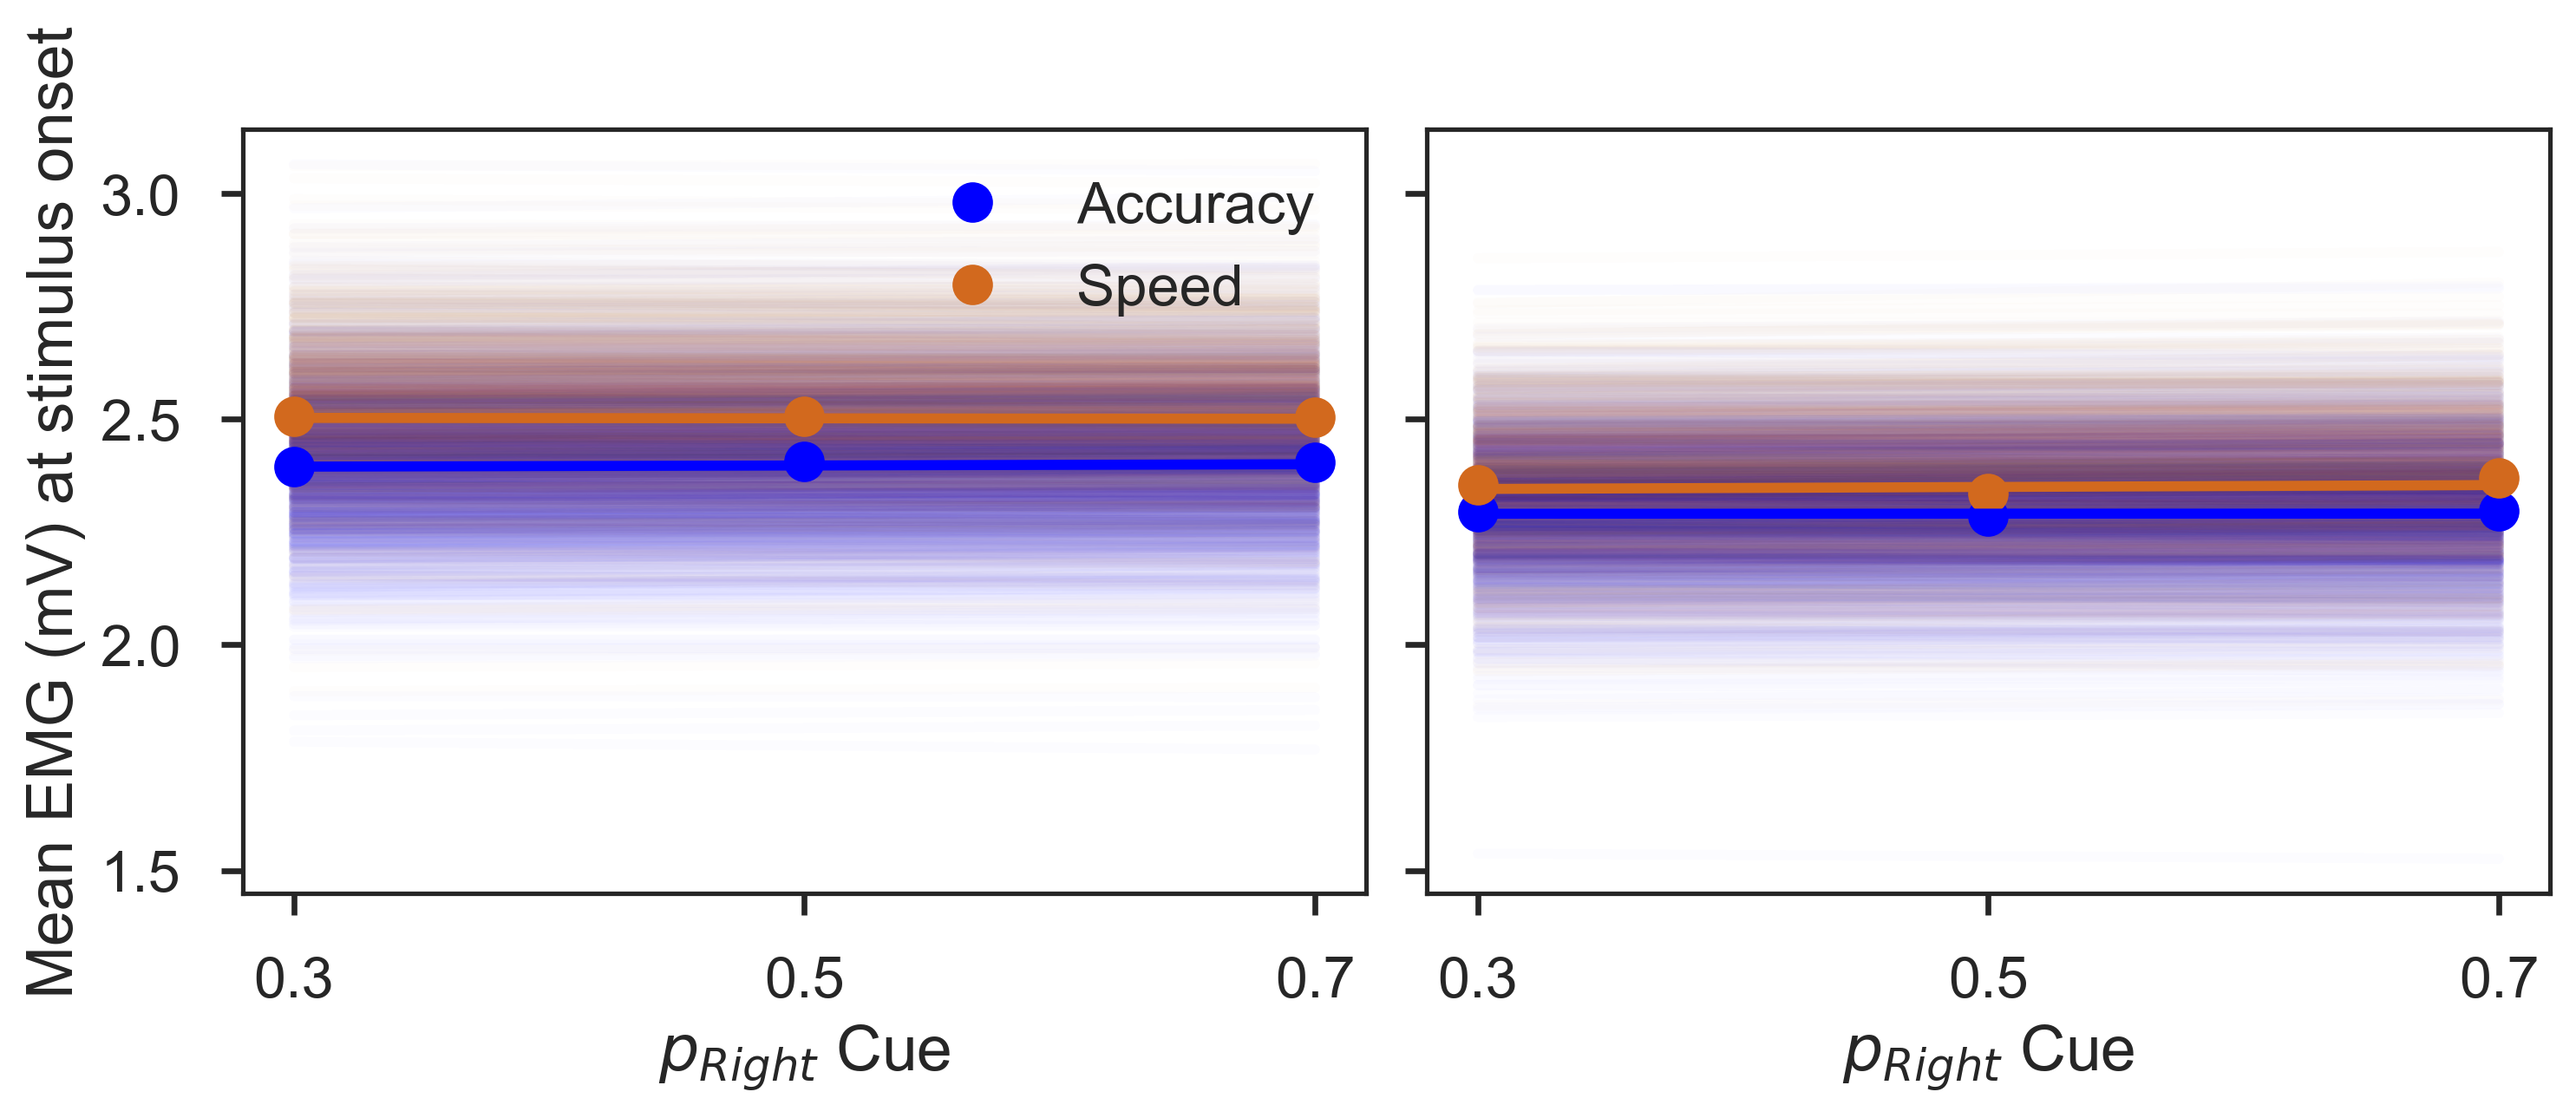

In [94]:
from scipy.special import expit
from random import sample

plt.style.use('seaborn-poster')


fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,4), sharex=True, dpi=300)

display_range = x = p_right = np.asarray([-0.5, 0, .5])

fixeff_form = "1+SAT+p_right+EMG+SAT:p_right+SAT:EMG+EMG:p_right+SAT:EMG:p_right"#Fixed effects formula
param_dict = {val : idx for idx, val in enumerate(fixeff_form.split('+')[1:])} 
fit = baseline_fit
alpha, beta = fit.posterior.alpha, fit.posterior.beta
samples,chains = fit.posterior.draw.values,fit.posterior.chain.values
for z in [0,1]:
    for d in sample(list(samples),1000):
        c = np.random.choice(chains)
        intercept, bSAT, bp_right, bEMG, bSATp_right, bSATEMG, bEMGp_right, bSATEMGp_right =  \
            alpha.sel(draw=d, chain=c).values, beta.sel(draw=d, chain=c, beta_dim_0=param_dict["SAT"]).values,\
            beta.sel(draw=d, chain=c, beta_dim_0=param_dict["p_right"]).values, beta.sel(draw=d, chain=c, beta_dim_0=param_dict["EMG"]).values,\
            beta.sel(draw=d, chain=c, beta_dim_0=param_dict["SAT:p_right"]).values, beta.sel(draw=d, chain=c, beta_dim_0=param_dict["SAT:EMG"]).values,\
            beta.sel(draw=d, chain=c, beta_dim_0=param_dict["EMG:p_right"]).values, beta.sel(draw=d, chain=c, beta_dim_0=param_dict["SAT:EMG:p_right"]).values        
        ax[z].plot(display_range, intercept+bSAT*1+bp_right*p_right+bEMG*z+bSATp_right*1*p_right+bSATEMG*1*z+bEMGp_right*p_right*z+bSATEMGp_right*1*z*p_right, color="blue", alpha=.01)#when SAT = 0
        ax[z].plot(display_range, intercept+bSAT*0+bp_right*p_right+bEMG*z+bSATp_right*0*p_right+bSATEMG*0*z+bEMGp_right*p_right*z+bSATEMGp_right*0*z*p_right, color="chocolate", alpha=.01)#when SAT = 0
    intercept, bSAT, bp_right, bEMG, bSATp_right, bSATEMG, bEMGp_right, bSATEMGp_right =  \
        alpha.mean(axis=(0,1)).values, beta.sel(beta_dim_0=param_dict["SAT"]).mean(axis=(0,1)).values,\
        beta.sel(beta_dim_0=param_dict["p_right"]).mean(axis=(0,1)).values, beta.sel(beta_dim_0=param_dict["EMG"]).mean(axis=(0,1)).values,\
        beta.sel(beta_dim_0=param_dict["SAT:p_right"]).mean(axis=(0,1)).values, beta.sel(beta_dim_0=param_dict["SAT:EMG"]).mean(axis=(0,1)).values,\
        beta.sel(beta_dim_0=param_dict["EMG:p_right"]).mean(axis=(0,1)).values, beta.sel(beta_dim_0=param_dict["SAT:EMG:p_right"]).mean(axis=(0,1)).values

    data = LMEdata[LMEdata.EMG == z].copy()
    data['SAT'] = data.SAT.replace([1,0], ['accuracy','speed'])
    F1 = data[(data.SAT=="accuracy")].groupby(['participant','p_right']).mean().groupby('p_right') #Strong force only
    F2 = data[(data.SAT=="speed")].groupby(['participant','p_right']).mean().groupby('p_right') #Strong force only
    ax[z].plot( x, F1.channel.mean().values,'o',color="blue", markeredgecolor ="k", label="Accuracy")
    ax[z].plot( x, F2.channel.mean().values,'o',color="chocolate", markeredgecolor ="k", label="Speed")
    
    ax[z].plot(display_range, intercept+bSAT*1+bp_right*p_right+bEMG*z+bSATp_right*1*p_right+bSATEMG*1*z+bEMGp_right*p_right*z+bSATEMGp_right*1*z*p_right, color="blue")
    ax[z].plot(display_range, intercept+bSAT*0+bp_right*p_right+bEMG*z+bSATp_right*0*p_right+bSATEMG*0*z+bEMGp_right*p_right*z+bSATEMGp_right*0*z*p_right, color="chocolate")
    ax[z].set_xlabel('p_right')
    ax[z].set_xticks([-0.5, 0, 0.5])
    ax[z].set_xticklabels(['0.3','0.5','0.7'])
    ax[z].set_xlabel(r'$p_{Right}$ Cue')
    if z == 0 :
        ax[z].set_ylabel('Mean EMG (mV) at stimulus onset')
        ax[z].legend(loc=1)
plt.tight_layout()
plt.show()

In [99]:
def plot_resid(fit):
    from scipy.stats import probplot
    observed = fit.observed_data.y.values 
    predicted = np.mean(fit.posterior_predictive.y_hat.values, axis=(0,1)) 
    residuals = observed - predicted
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=[15,7])
    probplot(residuals, dist="norm", plot=ax1)
    ax2.plot(np.sort(observed, kind='mergesort'), residuals, '.')
    ax2.plot([observed.min(), observed.max()],[0,0],linestyle='--', color='r')

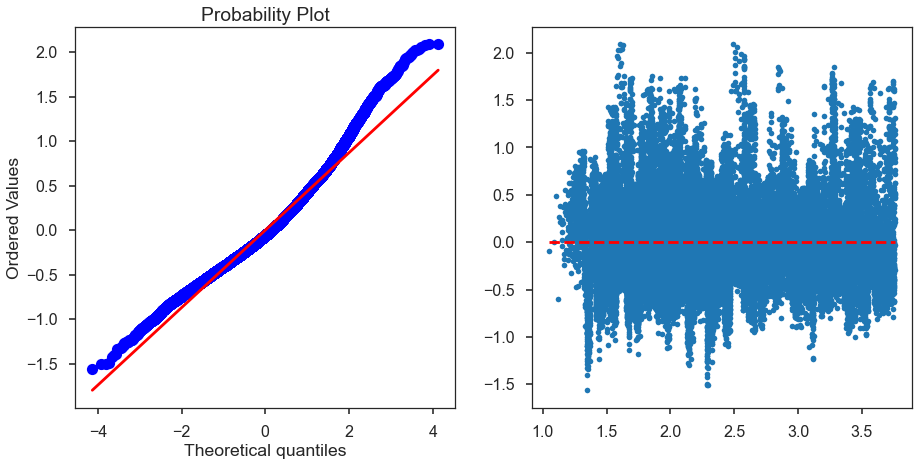

In [101]:
plot_resid(baseline_fit)